In [1]:
import jax
import jax.numpy as jnp
from jax import random
from jax import tree_util as jtu
import numpy as np
import matplotlib.pyplot as plt
import copy 
import pandas as pd
import glob
import sys
import yaml

sys.path.append('../refactored_scripts/')

from model_building import get_theta_shape, build_xyz_basis, build_lindblad_operators, prepare_initial_state
from diagnostics import print_training_info, print_hamiltonian_parameters, print_noise_parameters, print_relative_error, generate_diagnostic_trajectories
from mlp import init_mlp_params, mlp_forward, make_step_fn, train_phase
from figures import plot_noise_parameters, plot_hamiltonian_parameters, plot_mixed_state_fidelity, plot_purity, plot_pure_state_fidelity, plot_observables, plot_training_loss

Array = jnp.ndarray

In [2]:
def load_config(config_path):
    '''Load configuration from YAML file'''
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

def load_experimental_data(config):
    """Load experimental/simulated data"""
    N = config["L"]
    T_max = config["t_max"]
    search_pattern = f"experimental_data_quantum_sampling_L{N}_*_counts.csv"
    files = glob.glob(search_pattern)

    if not files:
        raise FileNotFoundError(f"No data found for L={N}")

    config_file = files[0]
    file_core = config_file.replace(".csv", "").replace("experimental_data_quantum_sampling_", "")
    
    print(f"\n{'='*60}")
    print(f"LOADING DATA: {file_core}")
    print(f"{'='*60}")
    
    df_counts = pd.read_csv(f"experimental_data_quantum_sampling_{file_core}.csv")
        
    # Remove leading single quote if present
    if df_counts['bitstring'].astype(str).str.startswith("'").all():
        df_counts['bitstring'] = df_counts['bitstring'].str[1:]
    
    # Now extract values
    bitstrings = df_counts['bitstring'].values.astype(str)
    counts_shots = df_counts['count'].values.astype(np.int32)
    
    return bitstrings, counts_shots

In [3]:
config_file = "/Users/omichel/Desktop/qilimanjaro/projects/retech/retech_2025/config_files/lindbladian_learning_configuration.yaml"
#load configuration
CONFIG = load_config(config_file)
#Print useful information

In [4]:
# Load data
bitstrings, counts_shots = load_experimental_data(CONFIG)


LOADING DATA: L4_Chi_4_R10000_counts



MODEL configURATION
  Dynamics: Schrödinger (noiseless)
  Hamiltonian type: uniform_xyz
  Hamiltonian parameters: 6
  Model type: white
  Learn θ: True

TRAINING
  Phase 1 (Warm-up): 200 epochs
  Phase 2 (Distill): 200 epochs
  Phase 3 (Refine): 100 epochs

=== DEBUGGING PARAMETER MISMATCH ===
L (system size): 4
Hamiltonian type: uniform_xyz
Expected theta shape: 6
Actual theta init length: 6
OPS_XYZ length: 6

--- Phase: P1 Warm-up ---
  θ: TRAIN, φ: TRAIN, γ: FROZEN


/Users/omichel/.pyenv/versions/retech_env/lib/python3.12/site-packages/jax/_src/lax/lax.py:5518: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


  [020/200] Loss: 2.7127e+00 | NLL: 2.6387e+00 | Reg_NN: 7.4091e-01 | Reg_Noise: 0.0000e+00
  [040/200] Loss: 2.6534e+00 | NLL: 2.6149e+00 | Reg_NN: 3.8415e-01 | Reg_Noise: 0.0000e+00
  [060/200] Loss: 2.6272e+00 | NLL: 2.6033e+00 | Reg_NN: 2.3884e-01 | Reg_Noise: 0.0000e+00
  [080/200] Loss: 2.6085e+00 | NLL: 2.5939e+00 | Reg_NN: 1.4538e-01 | Reg_Noise: 0.0000e+00
  [100/200] Loss: 2.5977e+00 | NLL: 2.5870e+00 | Reg_NN: 1.0767e-01 | Reg_Noise: 0.0000e+00
  [120/200] Loss: 2.5941e+00 | NLL: 2.5848e+00 | Reg_NN: 9.3168e-02 | Reg_Noise: 0.0000e+00
  [140/200] Loss: 2.5922e+00 | NLL: 2.5847e+00 | Reg_NN: 7.5657e-02 | Reg_Noise: 0.0000e+00
  [160/200] Loss: 2.5907e+00 | NLL: 2.5847e+00 | Reg_NN: 5.9951e-02 | Reg_Noise: 0.0000e+00
  [180/200] Loss: 2.5894e+00 | NLL: 2.5846e+00 | Reg_NN: 4.8142e-02 | Reg_Noise: 0.0000e+00
  [200/200] Loss: 2.5883e+00 | NLL: 2.5845e+00 | Reg_NN: 3.8427e-02 | Reg_Noise: 0.0000e+00

--- Phase: P2 Distill ---
  θ: TRAIN, φ: FROZEN, γ: FROZEN
  [020/200] Loss: 2.

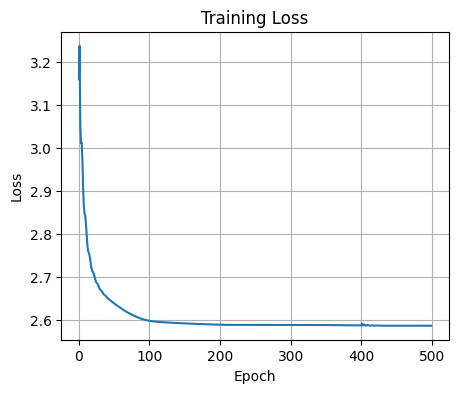

In [5]:
L = CONFIG["L"]
dim = 2**L
hamiltonian_type = CONFIG["hamiltonian_type"]
use_noisy = CONFIG["use_noisy_dynamics"]

# Prepare initial state
state0 = prepare_initial_state(L, CONFIG["initial_state_kind"], 
                                as_density_matrix=use_noisy)

# Build operators
OPS_XYZ = build_xyz_basis(L, hamiltonian_type)
NUM_COEFFICIENTS = get_theta_shape(L, hamiltonian_type)

# Build Lindblad operators if needed
if use_noisy:
    dephasing_ops, damping_ops = build_lindblad_operators(L)
else:
    dephasing_ops, damping_ops = None, None


print_training_info(CONFIG, NUM_COEFFICIENTS)

t_max = CONFIG['t_max']
dt = CONFIG['dt']
t_grid_shots = np.linspace(0., t_max, int(t_max/dt) +1)



# Initialize NN
NN_MAP_FUN = mlp_forward
NN_INPUT_DIM = 1  # Time-dependent
NN_OUTPUT_DIM = NUM_COEFFICIENTS  # NN only outputs Hamiltonian corrections

layer_sizes = [NN_INPUT_DIM] + CONFIG["NN_hidden_sizes"] + [NN_OUTPUT_DIM]
key = random.PRNGKey(CONFIG["seed_init"])
key, k_nn, k_th, k_noise = random.split(key, 4)
nn_params = init_mlp_params(layer_sizes, k_nn, scale=0.1)

# Initialize Hamiltonian parameters
if hamiltonian_type == "uniform_xyz":
    theta_init_list = [CONFIG["Jx_init"], CONFIG["Jy_init"], CONFIG["Jz_init"],
                        CONFIG["hx_init"], CONFIG["hy_init"], CONFIG["hz_init"]]
elif hamiltonian_type == "general_local_zz":
    theta_init_list = (list(CONFIG["hx_list_init"]) + 
                        list(CONFIG["hz_list_init"]) + 
                        list(CONFIG["Jzz_list_init"]))
else:
    raise ValueError(f"Unknown hamiltonian_type: {hamiltonian_type}")

theta_init = jnp.array(theta_init_list, dtype=jnp.float32)
if CONFIG["INIT_PERTURB_SCALE"] > 0:
    theta_init += CONFIG["INIT_PERTURB_SCALE"] * random.normal(k_th, (NUM_COEFFICIENTS,))

# Initialize noise parameters if needed
params = {"theta": theta_init, "nn": nn_params}

if use_noisy and CONFIG["learn_noise_params"]:
    if CONFIG["noise_model"] == "global":
        # Single rate for all qubits
        noise_rates_init = jnp.array([
            CONFIG["gamma_dephasing_init"],
            CONFIG["gamma_damping_init"]
        ], dtype=jnp.float32)
    else:  # local
        # Per-qubit rates
        noise_rates_init = jnp.concatenate([
            jnp.full((L,), CONFIG["gamma_dephasing_init"], dtype=jnp.float32),
            jnp.full((L,), CONFIG["gamma_damping_init"], dtype=jnp.float32)
        ])
    params["noise_rates"] = noise_rates_init
    print(f"  Initial noise rates: {noise_rates_init}")

# Create time grids
t_grid_fine = jnp.arange(0.0, CONFIG["t_max"] + CONFIG["dt"]/2, CONFIG["dt"])
T_extrap = CONFIG["t_max"] * CONFIG["T_extrapolate_factor"]
t_grid_long = jnp.arange(0.0, T_extrap + 1e-12, CONFIG["dt"])

# Create step function
step_fn = make_step_fn(CONFIG, L, OPS_XYZ, NN_MAP_FUN, use_noisy,
                        dephasing_ops, damping_ops)

# Training schedule
N_total = CONFIG["N_epochs"]
P1 = int(N_total * CONFIG["PHASE1_SPLIT"])
P2 = int(N_total * CONFIG["PHASE2_SPLIT"])
P3 = N_total - P1 - P2

print(f"\n{'='*60}")
print(f"TRAINING")
print(f"{'='*60}")
print(f"  Phase 1 (Warm-up): {P1} epochs")
print(f"  Phase 2 (Distill): {P2} epochs")
print(f"  Phase 3 (Refine): {P3} epochs")


print("\n=== DEBUGGING PARAMETER MISMATCH ===")
print(f"L (system size): {L}")
print(f"Hamiltonian type: {hamiltonian_type}")
print(f"Expected theta shape: {NUM_COEFFICIENTS}")
print(f"Actual theta init length: {len(theta_init)}")
print(f"OPS_XYZ length: {len(OPS_XYZ)}")

# Phase 1: Train everything
learn_noise_p1 = CONFIG["learn_noise_params"] if use_noisy else False
params, l1 = train_phase(params, P1, CONFIG, step_fn, t_grid_shots, state0,
                        counts_shots, train_theta=CONFIG["learn_theta"],
                        train_nn=True, train_noise=learn_noise_p1,
                        phase_name="P1 Warm-up")

# Phase 2: Distill to theta (freeze NN and noise)
params, l2 = train_phase(params, P2, CONFIG, step_fn, t_grid_shots, state0,
                        counts_shots, train_theta=CONFIG["learn_theta"],
                        train_nn=False, train_noise=False,
                        phase_name="P2 Distill")

# Phase 3: Refine NN (freeze theta, optionally train noise)
learn_noise_p3 = CONFIG["learn_noise_params"] if use_noisy else False
params, l3 = train_phase(params, P3, CONFIG, step_fn, t_grid_shots, state0,
                        counts_shots, train_theta=False,
                        train_nn=True, train_noise=learn_noise_p3,
                        phase_name="P3 Refine")

losses = l1 + l2 + l3

# Extract final parameters
theta_final = np.array(jax.device_get(params["theta"]))
nn_l2_norm = sum(jnp.sum(p**2) for p in jtu.tree_leaves(params["nn"]))


print(f"\n{'='*60}")
print(f"FINAL RESULTS")
print(f"{'='*60}")

print_hamiltonian_parameters(CONFIG, hamiltonian_type, theta_final, nn_l2_norm)

# Print noise parameters if learned
if "noise_rates" in params:
    print_noise_parameters(CONFIG, params)

# # Compare with true parameters
# if theta_true_array is not None:
#     print_relative_error(theta_true_array, theta_final)
#     theta_true = np.array(theta_true_array)
# else:
#     theta_true = None

# # Generate trajectories for diagnostics
# print(f"\nGenerating trajectories for diagnostics...")

# traj_model, traj_vanilla, traj_true, obs_true, obs_model, obs_vanilla = generate_diagnostic_trajectories(CONFIG, OPS_XYZ, NN_MAP_FUN, 
#                                                                                                         dephasing_ops, damping_ops, 
#                                                                                                         state0, t_grid_long, params, theta_true)
# # PLOTTING
# print(f"\nGenerating plots...")

# # 1. Hamiltonian parameters
# fig_ham = plot_hamiltonian_parameters(theta_true, np.array(theta_init), 
#                                         theta_final, hamiltonian_type, L)
# plt.show()

# 2. Noise parameters (if applicable)
if "noise_rates" in params:
    true_noise_rates = None
    noise_model = CONFIG.get("noise_model", "global")
    
    # Extract true rates based on noise model
    if noise_model == "global":
        if "gamma_deph_true" in CONFIG and "gamma_damp_true" in CONFIG:
            true_noise_rates = [CONFIG["gamma_deph_true"], CONFIG["gamma_damp_true"]]
    else:  # local noise model
        if "gamma_deph_list_true" in CONFIG and "gamma_damp_list_true" in CONFIG:
            # Concatenate dephasing rates first, then damping rates
            true_noise_rates = np.concatenate([
                np.array(CONFIG["gamma_deph_list_true"]),
                np.array(CONFIG["gamma_damp_list_true"])
            ])
    
    # Learned noise rates (convert to numpy)
    try:
        learned_noise_rates = np.array(jax.device_get(params["noise_rates"]))
    except Exception as e:
        print(f"  Warning: failed to get learned noise rates: {e}")
        learned_noise_rates = None
    
    # Plot noise parameters
    if learned_noise_rates is not None:
        try:
            fig_noise = plot_noise_parameters(learned_noise_rates, true_noise_rates, noise_model, L)
            plt.show()
        except Exception as e:
            print(f"  Warning: failed to plot noise parameters: {e}")
    else:
        print("  Warning: No learned noise rates to plot")


# 3. Fidelity / Purity diagnostics
print("\nComputing fidelity and purity diagnostics...")

if use_noisy: 
    try:
        # Mixed-state fidelity
        traj_model_np, traj_van_np = plot_mixed_state_fidelity(traj_model, traj_vanilla, traj_true, CONFIG, t_grid_long, L)
        # Purity trajectories
        plot_purity(traj_model_np, traj_van_np, t_grid_long, CONFIG)
    except Exception as e:
        print(f"  Warning: failed mixed-state diagnostics: {e}")

else:
    # Pure-state fidelity (same style as original script)
    try:
        plot_pure_state_fidelity(traj_model, traj_vanilla, traj_true, CONFIG, t_grid_long, L)
    except Exception as e:
        print(f"  Warning: failed pure-state diagnostics: {e}")

# 4. Observables
# try:
#     fig_obs = plot_observables(t_grid_long, obs_true, obs_model, obs_vanilla, L, hamiltonian_type, CONFIG)
#     plt.show()
# except Exception as e:
#     print(f"  Warning: failed to plot observables: {e}")

# 5. Training loss
try:
    plot_training_loss(losses)
except Exception as e:
    print(f"  Warning: failed to plot training loss: {e}")